20240726 접촉 Stiffness 시뮬레이션 비교

* 필요 패키지 사용

In [20]:
import numpy as np
import mujoco
import mujoco.viewer
import mediapy as media

import time
import serpenoid
import serpenoid_gamma

from scipy.signal import find_peaks

* 시뮬레이션 정의 파일 불러오기

In [21]:
debris = mujoco.MjModel.from_xml_path("./contact_testing_fsensor.xml")
data = mujoco.MjData(debris)
renderer = mujoco.Renderer(debris, 720, 1280)


* 시뮬레이션 진행 (영상 렌더링)

In [22]:
debris = mujoco.MjModel.from_xml_path("./contact_testing_fsensor.xml")
data = mujoco.MjData(debris)
renderer = mujoco.Renderer(debris, 720, 1280)

t_step = debris.opt.timestep
stepspersecond = int(1/t_step)

frames = []
contact_force = []
debris_pos = []

mujoco.mj_resetData(debris, data)

mujoco.mj_forward(debris, data)

for i in range(2*stepspersecond):
    mujoco.mj_step(debris, data)
    renderer.update_scene(data)
    pixel = renderer.render()

    frames.append(pixel)
    contact_force.append(data.sensordata[2])
    debris_pos.append(data.body("debris").xpos[2])

initial_heght = debris_pos[0]
debris_pos = debris_pos - debris_pos[0]

pos_peak, _ = find_peaks(debris_pos, prominence=0.00001)
peak_len = len(pos_peak)

damp_peak, _ = find_peaks(contact_force, prominence=0.00001)
damp_peak_m, _ = find_peaks(-1*contact_force)
damp_peak_len = len(damp_peak)
# plt.plot(debris_pos[0:4000])
# plt.plot(contact_force)

if peak_len > 0:
    COR = np.sqrt((initial_heght + debris_pos[pos_peak[0]])/(initial_heght))
else:
    COR = 0.1

steady_gnd = np.mean(debris_pos[-3000::])

peak_force = -np.min(contact_force)
idx_peak_force = np.argmin(contact_force)

deform = -(0.4 + steady_gnd)


print(COR, peak_force, deform)
print(pos_peak)
print(damp_peak)
print(damp_peak_m)
print(idx_peak_force)

# media.show_video(frames, fps=stepspersecond)

0.1 37.84278557859184 -0.024677469698027144
[]
[ 313  328  353  365  378  395  403  407  414  427  431  438  445  449
  452  459  463  468  470  477  484  488  492  494  499  501  504  506
  511  513  518  524  527  531  534  538  540  549  557  560  567  572
  576  585  596  606  615  627  631  637  641  651  659  665  669  674
  680  684  686  695  708  721  730  733  738  749  764  779  789  792
  796  802  814  825  835  844  846  855  871  887  896  901  907  917
  937  954  962  965  967  975  989 1002 1011 1014 1019 1030 1044 1054
 1062 1068 1072 1074 1082 1096 1108 1116 1121 1125 1129 1134 1136 1142
 1150 1156 1163 1172 1176 1181 1192 1205 1218 1222 1228 1231 1238 1247
 1258 1268 1274 1276 1279 1288 1301 1314 1322 1326 1331 1342 1356 1366
 1374 1381 1383 1389 1391 1395 1399 1401 1406 1410 1414 1419 1426 1432
 1435 1437 1446 1459 1472 1482 1487 1489 1496 1505 1516 1527 1532 1535
 1539 1545 1548 1551 1556 1566 1575 1579 1583 1593 1611 1624 1633 1636
 1646 1658 1667 1677 1682 1687

[  0.          -2.57509286  -5.15018571  -7.72527857 -10.30037143
 -12.87546429 -15.45055714 -18.02565    -20.60074286 -23.17583571
 -25.75092857 -28.32602143 -30.90111429 -33.47620714 -36.0513
 -33.47620714 -30.90111429 -28.32602143 -25.75092857 -23.17583571
 -20.60074286 -18.02565    -15.45055714 -12.87546429 -10.30037143
  -7.72527857  -5.15018571  -2.57509286   0.        ]
228.73483219165416


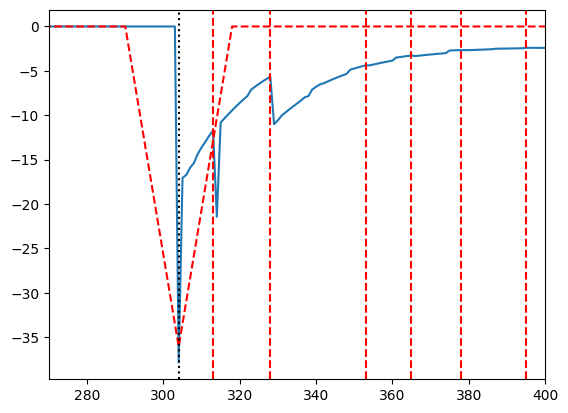

In [23]:
import matplotlib.pyplot as plt

plt.plot(contact_force[0:650])
for i in range(len(damp_peak)):
    plt.axvline(x=damp_peak[i], color='r', linestyle='--')


### 미분관련 실험
# d_contact_force = np.diff(contact_force)
# d_force_peak, _ = find_peaks(d_contact_force, prominence=0.00001)
# plt.plot(d_contact_force[0:650])

# for i in range(len(d_force_peak)):
#     plt.axvline(x=d_force_peak[i], color='g', linestyle='--')

### linspace 관련 실험
MAX_force_ref = 36.0513
contact_duration = 30

before_contact = np.linspace(0, -1 * MAX_force_ref, int((contact_duration+1)/2))
after_contact = np.linspace(-1 * MAX_force_ref, 0, int((contact_duration+1)/2))

ref_plot = np.zeros(650)
ref_plot[(idx_peak_force - (int((contact_duration+1)/2))) + 1 : idx_peak_force + 1] = before_contact
ref_plot[idx_peak_force:(idx_peak_force + (int((contact_duration+1)/2)))] = after_contact

rmse = np.square(np.subtract(contact_force[idx_peak_force - int((contact_duration+1)/2) + 1:idx_peak_force + int((contact_duration+1)/2)], ref_plot[idx_peak_force - int((contact_duration+1)/2) + 1:idx_peak_force + int((contact_duration+1)/2)])).mean()

print(ref_plot[idx_peak_force - int((contact_duration+1)/2) + 1:idx_peak_force + int((contact_duration+1)/2)])
print(rmse)

plt.plot(ref_plot, color='r', linestyle='--')

real_data_before_contact = contact_force[idx_peak_force - int((contact_duration+1)/2):idx_peak_force]

    
plt.axvline(x=idx_peak_force, color='k', linestyle=':')
plt.xlim(270, 400)
plt.show()

In [24]:
MAX_force_ref = -60
contact_duration = 15

before_contact = np.linspace(0, -1 * MAX_force_ref, int((contact_duration+1)/2))
after_contact = np.linspace(-1 * MAX_force_ref, 0, int((contact_duration+1)/2))

real_data_before_contact = contact_force[idx_peak_force - int((contact_duration+1)/2):idx_peak_force]

# print(before_contact,after_contact)
print(real_data_before_contact)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


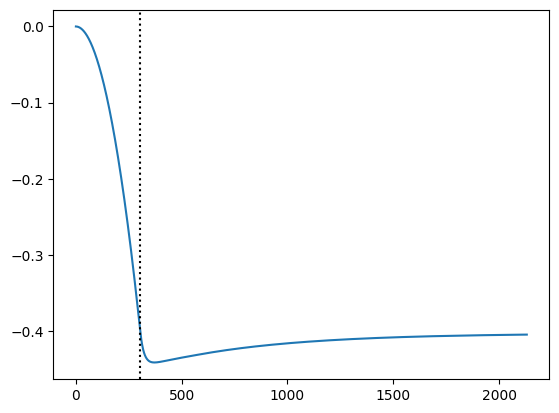

In [25]:
plt.plot(debris_pos[0:4000])

for i in range(len(pos_peak)):
    plt.axvline(x=pos_peak[i], color='r', linestyle='--')
plt.axvline(x=idx_peak_force, color='k', linestyle=':')
plt.show()